# Prática Machine Learning - CUNEF

## Alumno: Amadeo Gustavo Ancarani

### Definición del Script: 04_Model_Interpretation_Conclutions  

En el presente script se analiza de que manera trabaja internamente el algoritmo **XGBoost** para realizar una clasificación de fallecimientos. 

Esto debe concordar con la lógica esperable de algunas variables y además, ayuda a comprender posibles mejoras sobre el tratamiento de las mismas.

# 0. Importo las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import pickle
from xgboost import XGBClassifier, plot_importance
import shap

# 1. Explicación del modelo seleccionado

`XGBoost` es una implementación de código abierto y eficiente del algoritmo de **gradiente de árboles reforzados.** `Gradient boosting` es un algoritmo de aprendizaje supervisado, que intenta predecir con precisión una variable objetivo combinando las estimaciones de un conjunto de modelos más simples y débiles.

Este algoritmo, como todos, minimiza una función objetivo regularizada (L1 o L2) que combina una función de pérdida convexa (basada en la diferencia entre los outputs y los resultados reales) y un término de penalización para la complejidad del modelo (en otras palabras, las funciones del árbol de regresión). 

La capacitación continúa de manera iterativa (como se representa en **boosting** en la imagen), agregando nuevos árboles que predicen los residuos o errores de árboles anteriores que luego se combinan con árboles anteriores para hacer la predicción final. Se llama aumento de gradiente porque utiliza un algoritmo de descenso de gradiente para minimizar la pérdida al agregar nuevos modelos. (Fuente: documentación de AWS)

![Boosting](../images/boosting.png)

Es uno de los algoritmos supervisados de Machine Learning que más se usan en la actualidad. Esto se debe por su facilidad de implementación, sus buenos resultados y porque está predefinido en un montón de lenguajes.

Se trata de un algoritmo paralelizable. Esto nos permite usar de manera óptima toda la potencia de procesado de la que disponemos hoy en día. Se pueden utilizar múltiples núcleos a la vez.

# 2. Importo el modelo ganador

In [2]:
model_list = ['grid_search_gb_smote' ]

best_model_grid = []
for model in model_list:
    ''' use after the model is pickled '''
    if model == 'grid_search':
        classifier_f = open('../models/'+ model +'.pickle',"rb")
    elif model == 'grid_search_gb_smote':
        classifier_f = open('../models/'+ model +'.pickle',"rb")
    else:
        classifier_f = open('../models/'+ model +'_personal_prob.pickle',"rb")
    best_model_grid.append(pickle.load(classifier_f))
    classifier_f.close()
    
best_model_grid

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='aucpr', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=400, n_jobs=8,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=7, subsample=1,
               tree_method='approx', validate_parameters=1, verbosity=None)]

# 3. Importo datasets

In [3]:
train = pd.read_csv("../data/train_data_personal_prob.csv",low_memory=False)
train.set_index(['Unnamed: 0'], inplace=True)
train.index.names = ['']

test = pd.read_csv("../data/test_data_personal_prob.csv",low_memory=False)
test.set_index(['Unnamed: 0'], inplace=True)
test.index.names = ['']

ytrain = train['C_SEV']
xtrain = train.drop(columns=['C_SEV'])

ytest = test['C_SEV']
xtest = test.drop(columns=['C_SEV'])

# 4. Observo la importancia de las variables para el modelo

In [4]:
plt.rcParams["figure.figsize"] = (20,13)

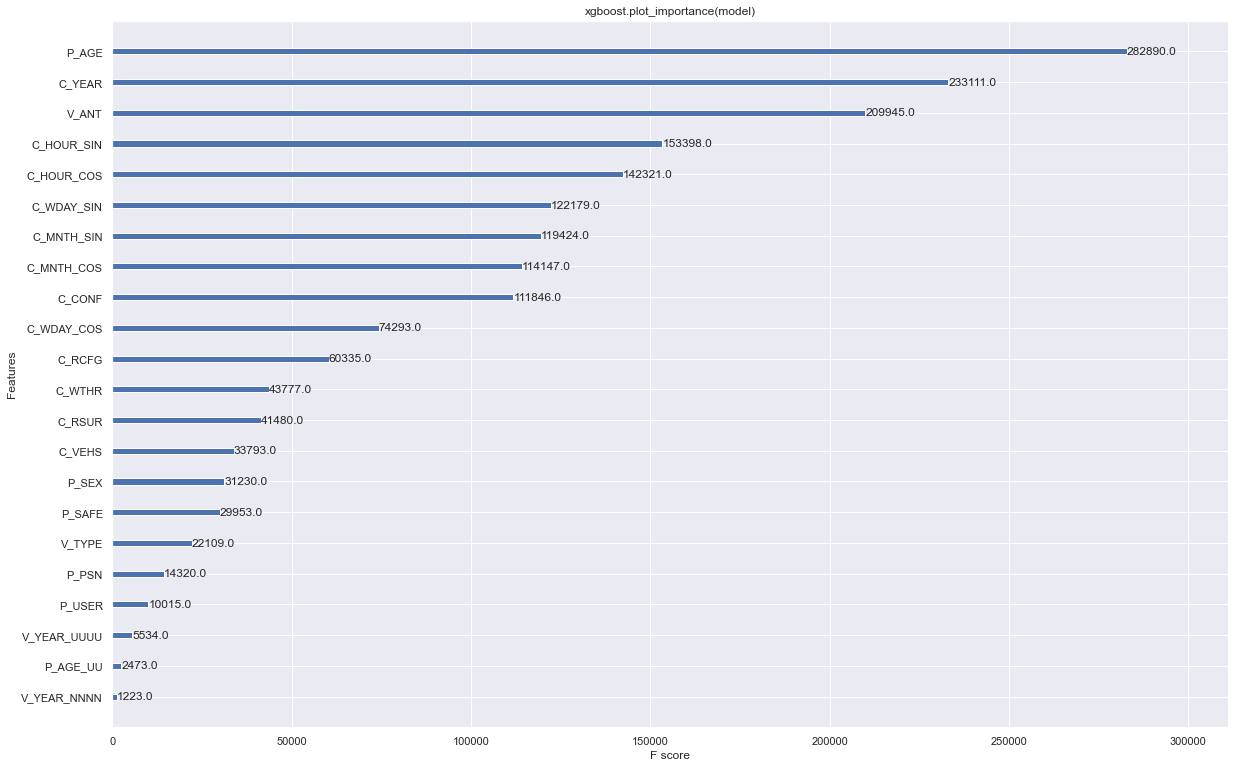

In [5]:
plot_importance(best_model_grid[0])
#plt.rcParams["figure.figsize"] = (20,13)
plt.title("xgboost.plot_importance(model)")
plt.show();

Vemos que la edad es la variable más importante del modelo, eso puede tener lógica ya que en las edades mas avanzadas es esperable que tengan mayor probabilidad de muerte ante un accidente.

La variable año del accidente puede ser dificil de interpretar ya que puede haber un año en el cual la mayor cantidad de accidentes fatales. Quizás, al pasar los años, la cantidad de accidentes fatales desciendan ya que con el tiempo mejoran las carreteras y los automóviles.

La tarcera variable tiene una lógica fácil de interpretar ya que la antigüedad de los automóviles son muy influyentes en la probabilidad de fallecer en un accidente.  

# 5. Vemos el efecto real de las variables en una predicción específica

In [7]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(best_model_grid[0], approximate=True)

# Calculate Shap values
shap_values = explainer.shap_values(xtest.iloc[:10000,:])

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], xtest.iloc[0,:])

Para el primer individuo de nuestro dataset de prueba, podemos notar que el modelo parte de un valor 'base' de 0.4691 y que luego de recibir diferentes modificaciones por las características propias de la persona en cuestión y el accidente en el cual estuvo involucrado, obtuvo un valor final de -13.03.

Lo valioso de este gráfico es que podemos tener una mejor idea de la proporción de impacto de cada variable sobre el resultado final de un único individuo. Si bien en general, como vimos anteriormente, la edad era la variable mas determinante, en este caso no fue así. De hecho, fue la cuarta variable que mayor contribución aportó.

En este caso, las variable del accidente fueron sumamente preponderantes para estimar si el individuo habría fallecido o no.

In [9]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=xtest.iloc[:100, :])

En este caso se analizan las distribuciones de 100 individuos y los efectos de las variables sobre cada individuo. Donde podemos ver casos en donde algunas variables tienen influencias positivas y negativas sobre el valor inicial observado.

# 6. Conclusiones Finales

Hemos logrado el mejor modelo posible dadas las restricciones de cómputo por el hecho de intentar estimar los modelos localmente en un ordenaror sin GPU (hardware vital para realizar modelos en paralelo). 

Sin embargo, creo que los resultados son aceptables y el modelo será utilizado para realizar las predicciones de la empresa a traves de una API.

# 7. Recomendaciones para actualizaciones futuras 

El tratamiento de aplicar seno y coseno sobre las variables temporales en el caso de modelos de árboles de decisión, no es del todo recomendable, ya que estos algoritmos trabajan sobre las variables de manera independiente.

Quizás es mejor aplicar un dataset para ciertos algoritmos con su respectivo preprocesamiento y aplicar difirentes tranformaciones para otros.